In [1]:
import pandas  as pd
import numpy as np
import random 
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
from itertools import chain
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_data =pd.read_csv("./dataset/train.csv", nrows = 100000)
destinations_data =pd.read_csv("./dataset/destinations.csv", nrows = 100000)

In [3]:
train_data.head()

date_time  site_name  posa_continent  user_location_country  \
0  2014-08-11 07:46:59          2               3                     66   
1  2014-08-11 08:22:12          2               3                     66   
2  2014-08-11 08:24:33          2               3                     66   
3  2014-08-09 18:05:16          2               3                     66   
4  2014-08-09 18:08:18          2               3                     66   

   user_location_region  user_location_city  orig_destination_distance  \
0                   348               48862                  2234.2641   
1                   348               48862                  2234.2641   
2                   348               48862                  2234.2641   
3                   442               35390                   913.1932   
4                   442               35390                   913.6259   

   user_id  is_mobile  is_package  ...  srch_children_cnt srch_rm_cnt  \
0       12          0           1  ...                  0           1   
1       12          0           1  ...                  0           1   
2       12          0           0  ...                  0           1   
3       93          0           0  ...                  0           1   
4       93          0           0  ...                  0           1   

  srch_destination_id  srch_destination_type_id  is_booking  cnt  \
0                8250                         1           0    3   
1                8250                         1           1    1   
2                8250                         1           0    1   
3               14984                         1           0    1   
4               14984                         1           0    1   

   hotel_continent  hotel_country  hotel_market  hotel_cluster  
0                2             50           628              1  
1                2             50           628              1  
2                2             50           628              1  
3                2             50          1457             80  
4                2             50          1457             21  

[5 rows x 24 columns]

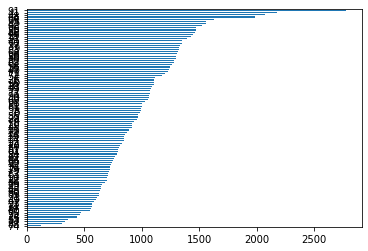

In [4]:
train_data.hotel_cluster.value_counts().sort_values().plot(kind = 'barh')

### The hotel cluster 91 has more no of visits

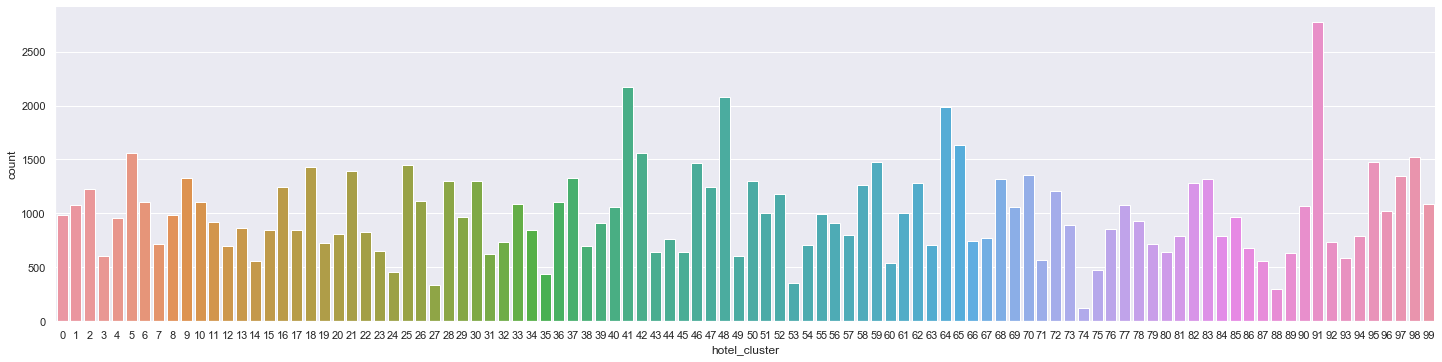

In [5]:
sns.set_theme(style="darkgrid")
sns.catplot(x="hotel_cluster", data=train_data, kind='count', aspect = 4)

### To get more insights, we are adding year and month extracted from date_time attribute

In [6]:
train_data["date_time"] = pd.to_datetime(train_data["date_time"])
train_data["month"] = train_data["date_time"].dt.month
train_data["year"] = train_data["date_time"].dt.year

In [7]:
train_data.head()

date_time  site_name  posa_continent  user_location_country  \
0 2014-08-11 07:46:59          2               3                     66   
1 2014-08-11 08:22:12          2               3                     66   
2 2014-08-11 08:24:33          2               3                     66   
3 2014-08-09 18:05:16          2               3                     66   
4 2014-08-09 18:08:18          2               3                     66   

   user_location_region  user_location_city  orig_destination_distance  \
0                   348               48862                  2234.2641   
1                   348               48862                  2234.2641   
2                   348               48862                  2234.2641   
3                   442               35390                   913.1932   
4                   442               35390                   913.6259   

   user_id  is_mobile  is_package  ...  srch_destination_id  \
0       12          0           1  ...                 8250   
1       12          0           1  ...                 8250   
2       12          0           0  ...                 8250   
3       93          0           0  ...                14984   
4       93          0           0  ...                14984   

  srch_destination_type_id is_booking  cnt  hotel_continent  hotel_country  \
0                        1          0    3                2             50   
1                        1          1    1                2             50   
2                        1          0    1                2             50   
3                        1          0    1                2             50   
4                        1          0    1                2             50   

   hotel_market  hotel_cluster  month  year  
0           628              1      8  2014  
1           628              1      8  2014  
2           628              1      8  2014  
3          1457             80      8  2014  
4          1457             21      8  2014  

[5 rows x 26 columns]

#### The training data has no linear correlation with any attributes in the dataset.

In [8]:
train_data.corr()["hotel_cluster"]

site_name                   -0.019154
posa_continent               0.002204
user_location_country       -0.025170
user_location_region         0.008037
user_location_city          -0.006580
orig_destination_distance    0.011362
user_id                      0.001396
is_mobile                   -0.002803
is_package                   0.051955
channel                     -0.005956
srch_adults_cnt              0.007322
srch_children_cnt            0.005469
srch_rm_cnt                 -0.005801
srch_destination_id         -0.007258
srch_destination_type_id    -0.030064
is_booking                  -0.025380
cnt                          0.000914
hotel_continent             -0.008441
hotel_country               -0.021170
hotel_market                 0.036107
hotel_cluster                1.000000
month                        0.001208
year                         0.000696
Name: hotel_cluster, dtype: float64

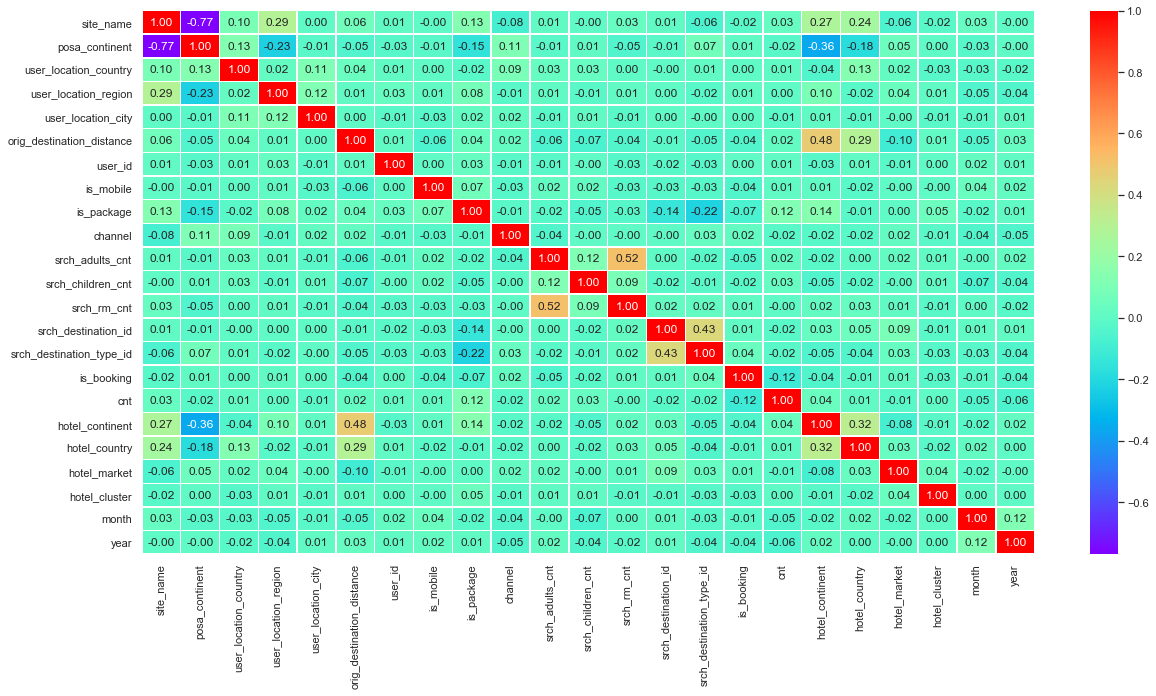

In [69]:
corr = train_data.corr()
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(round(corr, 2).iloc[:, :], annot=True, linewidths=.5, ax=ax, cmap="rainbow",fmt='.2f')

In [9]:
users_uni = train_data.user_id.unique()  
sampled_userids = []
for k in sorted(random.sample(range(len(users_uni)),100)):
    sampled_userids.append(users_uni[k])
    
sampled_train = train_data[train_data.user_id.isin(sampled_userids)]
sampled_train

date_time  site_name  posa_continent  user_location_country  \
24    2014-10-22 12:20:56          2               3                     66   
25    2014-11-10 12:38:02          2               3                     66   
120   2014-10-24 11:36:56          2               3                     66   
121   2014-10-24 11:43:49          2               3                     66   
122   2014-10-29 14:09:39          2               3                     66   
...                   ...        ...             ...                    ...   
99742 2013-06-16 09:57:18          2               3                     66   
99743 2013-06-16 10:07:08          2               3                     66   
99744 2014-08-24 04:08:12          2               3                     66   
99745 2014-08-24 04:09:19          2               3                     66   
99746 2014-10-19 08:49:30          2               3                     66   

       user_location_region  user_location_city  orig_destination_distance  \
24                      318               52997                    47.7027   
25                      318               48382                  1753.2617   
120                     174               40365                  5463.5637   
121                     174               40365                  8456.8294   
122                     174               40365                  8454.4977   
...                     ...                 ...                        ...   
99742                   220               45912                  1066.9288   
99743                   220               45912                  1067.0756   
99744                   220               45912                   478.2523   
99745                   220               45912                   474.8847   
99746                   220               45912                  3802.2842   

       user_id  is_mobile  is_package  ...  srch_destination_id  \
24         776          0           0  ...                27082   
25         776          0           1  ...                 8250   
120       1713          0           0  ...                12702   
121       1713          0           0  ...                 1571   
122       1713          0           0  ...                 1571   
...        ...        ...         ...  ...                  ...   
99742   389430          0           0  ...                24628   
99743   389430          0           1  ...                24628   
99744   389430          0           0  ...                17859   
99745   389430          0           1  ...                17859   
99746   389430          0           1  ...                 8214   

      srch_destination_type_id is_booking  cnt  hotel_continent  \
24                           6          0    2                2   
25                           1          0    1                2   
120                          5          0    2                0   
121                          3          0    1                3   
122                          3          0    1                3   
...                        ...        ...  ...              ...   
99742                        6          0    3                2   
99743                        6          0    4                2   
99744                        1          0    1                2   
99745                        1          0    1                2   
99746                        1          0    1                2   

       hotel_country  hotel_market  hotel_cluster  month  year  
24                50           641             77     10  2014  
25                50           628             24     11  2014  
120               87            58              6     10  2014  
121                5            89             38     10  2014  
122                5            89             46     10  2014  
...              ...           ...            ...    ...   ...  
99742             50           420             91      6  2013  


#### The data is split in training and testing. As test.csv contains data aged above 2014, the testing_set has been sampled accordingly

In [10]:
training_set = sampled_train[(((sampled_train.month < 8) & (sampled_train.year == 2014)) | (sampled_train.year == 2013))]
testing_set = sampled_train[((sampled_train.month >= 8) & (sampled_train.year == 2014))]

In [11]:
training_set.shape, testing_set.shape

((2031, 26), (1070, 26))

In [12]:
testing_set = testing_set[testing_set.is_booking == True]
testing_set.head()

date_time  site_name  posa_continent  user_location_country  \
128 2014-10-29 14:32:19          2               3                     66   
133 2014-12-05 09:58:15          2               3                     66   
818 2014-08-01 12:22:27         13               1                     46   
823 2014-08-11 09:51:49         13               1                     46   
825 2014-08-11 09:54:11         13               1                     46   

     user_location_region  user_location_city  orig_destination_distance  \
128                   174               40365                  8456.8294   
133                   174               21855                  8393.1607   
818                   171               15334                   119.4620   
823                   171               43659                        NaN   
825                   171               43659                        NaN   

     user_id  is_mobile  is_package  ...  srch_destination_id  \
128     1713          0           0  ...                 1571   
133     1713          0           0  ...                12861   
818     4539          0           0  ...                17459   
823     4539          0           0  ...                31208   
825     4539          0           0  ...                31208   

    srch_destination_type_id is_booking  cnt  hotel_continent  hotel_country  \
128                        3          1    1                3              5   
133                        5          1    1                3              5   
818                        5          1    1                6            144   
823                        4          1    1                6            144   
825                        4          1    1                6            144   

     hotel_market  hotel_cluster  month  year  
128            89             38     10  2014  
133            89             81     12  2014  
818            24             46      8  2014  
823             7             11      8  2014  
825             7             11      8  2014  

[5 rows x 26 columns]

#### Initially setting the recommended cluster values based on their value counts

In [13]:
initial_cluster_values = list(train_data.hotel_cluster.value_counts().head().index)
initial_cluster_values

[91, 41, 48, 64, 65]

In [14]:
top_five_clusters = []
clusters_count = testing_set.shape[0]
for cluster in range(clusters_count):
    top_five_clusters.append(initial_cluster_values)

In [15]:
training_set['hotel_cluster']

748      86
749      57
750      82
751      81
752      62
         ..
99531    70
99740    20
99741    20
99742    91
99743     8
Name: hotel_cluster, Length: 2031, dtype: int64

In [16]:
destinations_data.head()

srch_destination_id        d1        d2        d3        d4        d5  \
0                    0 -2.198657 -2.198657 -2.198657 -2.198657 -2.198657   
1                    1 -2.181690 -2.181690 -2.181690 -2.082564 -2.181690   
2                    2 -2.183490 -2.224164 -2.224164 -2.189562 -2.105819   
3                    3 -2.177409 -2.177409 -2.177409 -2.177409 -2.177409   
4                    4 -2.189562 -2.187783 -2.194008 -2.171153 -2.152303   

         d6        d7        d8        d9  ...      d140      d141      d142  \
0 -1.897627 -2.198657 -2.198657 -1.897627  ... -2.198657 -2.198657 -2.198657   
1 -2.165028 -2.181690 -2.181690 -2.031597  ... -2.165028 -2.181690 -2.165028   
2 -2.075407 -2.224164 -2.118483 -2.140393  ... -2.224164 -2.224164 -2.196379   
3 -2.115485 -2.177409 -2.177409 -2.177409  ... -2.161081 -2.177409 -2.177409   
4 -2.056618 -2.194008 -2.194008 -2.145911  ... -2.187356 -2.194008 -2.191779   

       d143      d144      d145      d146      d147      d148      d149  
0 -2.198657 -2.198657 -2.198657 -2.198657 -2.198657 -2.198657 -2.198657  
1 -2.181690 -2.181690 -2.165028 -2.181690 -2.181690 -2.181690 -2.181690  
2 -2.224164 -2.192009 -2.224164 -2.224164 -2.224164 -2.224164 -2.057548  
3 -2.177409 -2.177409 -2.177409 -2.177409 -2.177409 -2.177409 -2.177409  
4 -2.194008 -2.194008 -2.185161 -2.194008 -2.194008 -2.194008 -2.188037  

[5 rows x 150 columns]

In [17]:
pca = PCA(n_components=3)  
reduced_dest = pca.fit_transform(destinations_data[["d{0}".format(i+1) for i in range(149)]])
reduced_dest = pd.DataFrame(reduced_dest)  
reduced_dest["srch_destination_id"]= destinations_data["srch_destination_id"]

In [18]:
reduced_dest

0         1         2  srch_destination_id
0     -0.044268  0.169419  0.032520                    0
1     -0.440761  0.077405 -0.091571                    1
2      0.001033  0.020677  0.012109                    2
3     -0.480467 -0.040345 -0.019319                    3
4     -0.207253 -0.042694 -0.011746                    4
...         ...       ...       ...                  ...
62101  0.031398 -0.191479 -0.064769                64989
62102  0.071925 -0.174147  0.071125                64990
62103  0.166190  0.208037  0.217180                64991
62104 -0.581395 -0.027664 -0.054204                64992
62105 -0.376593 -0.011612  0.081419                64993

[62106 rows x 4 columns]

In [19]:
def features_imp(df):
    df["date_time"] = pd.to_datetime(df["date_time"])
    df["srch_ci"] = pd.to_datetime(df["srch_ci"], format='%Y-%m-%d', errors="coerce")
    df["srch_co"] = pd.to_datetime(df["srch_co"], format='%Y-%m-%d', errors="coerce")
    
    attributes = {}
    for col in ["month", "day", "hour", "minute", "dayofweek", "quarter"]:
        attributes[col] = getattr(df["date_time"].dt, col)
    
    extra_attr = []
    for col in df.columns:
        if col not in ["srch_ci", "date_time", "srch_co"]:
            extra_attr.append(col)
            
    for attr in extra_attr:
        attributes[attr] = df[attr]
    
    feature_dates = ["month", "day", "dayofweek", "quarter"]
    for attr in feature_dates:
        attributes["ci_{0}".format(attr)] = getattr(df["srch_ci"].dt, attr)
        attributes["co_{0}".format(attr)] = getattr(df["srch_co"].dt, attr)
    attributes["stay_span"] = (df["srch_co"] - df["srch_ci"]).astype('timedelta64[h]')
    updated_df = pd.DataFrame(attributes)
    updated_df = updated_df.join(reduced_dest, on="srch_destination_id", how='left', rsuffix="dest")
    updated_df = updated_df.drop("srch_destination_iddest", axis=1)
    return updated_df

In [20]:
new_df = features_imp(training_set)
new_df.fillna(-1, inplace=True)

C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [21]:
unique_clusters = new_df["hotel_cluster"].unique()

for cluster in unique_clusters:
    new_df["target_class"] = 1
    new_df['target_class'][new_df["hotel_cluster"] != cluster] = 0

C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [22]:
new_df

month  day  hour  minute  dayofweek  quarter  site_name  \
748        1   11    13      15          4        1         13   
749        1   28    10      45          0        1         13   
750        1   28    10      45          0        1         13   
751        1   28    10      46          0        1         13   
752        3   14    15      12          3        1         13   
...      ...  ...   ...     ...        ...      ...        ...   
99531     12   25     0      44          2        4         37   
99740      6   16     9      56          6        2          2   
99741      6   16     9      56          6        2          2   
99742      6   16     9      57          6        2          2   
99743      6   16    10       7          6        2          2   

       posa_continent  user_location_country  user_location_region  ...  \
748                 1                     46                   171  ...   
749                 1                     46                   171  ...   
750                 1                     46                   171  ...   
751                 1                     46                   171  ...   
752                 1                     46                   171  ...   
...               ...                    ...                   ...  ...   
99531               1                     69                   695  ...   
99740               3                     66                   220  ...   
99741               3                     66                   220  ...   
99742               3                     66                   220  ...   
99743               3                     66                   220  ...   

       co_day  ci_dayofweek  co_dayofweek  ci_quarter  co_quarter  stay_span  \
748      23.0           2.0           4.0         3.0         3.0       48.0   
749       2.0           6.0           1.0         1.0         2.0       48.0   
750       2.0           6.0           1.0         1.0         2.0       48.0   
751       2.0           6.0           1.0         1.0         2.0       48.0   
752      13.0           2.0           3.0         2.0         2.0       24.0   
...       ...           ...           ...         ...         ...        ...   
99531     3.0           0.0           4.0         4.0         1.0       96.0   
99740    15.0           4.0           6.0         3.0         3.0       48.0   
99741    15.0           4.0           6.0         3.0         3.0       48.0   
99742    15.0           4.0           6.0         3.0         3.0       48.0   
99743    15.0           4.0           6.0         3.0         3.0       48.0   

              0         1         2  target_class  
748   -0.369700 -0.032725  0.044645             0  
749   -0.214925 -0.133657 -0.158035             0  
750   -0.214925 -0.133657 -0.158035             0  
751   -0.214925 -0.133657 -0.158035             0  
752   -0.231304 -0.079319  0.024565             0  
...         ...       ...       ...           ...  
99531 -0.532439 -0.031186 -0.030728             0  
99740  0.418529 -0.221830  0.209521             0  
99741  0.418529 -0.221830  0.209521             0  
99742  0.418529 -0.221830  0.209521             0  
99743  0.418529 -0.221830  0.209521             0  

[2031 rows x 41 columns]

In [23]:
non_target_cols = []
for col in new_df:
        if col not in ['hotel_cluster', 'target_class']:
            non_target_cols.append(col)
len(non_target_cols)

39

In [24]:
X, y = new_df[non_target_cols], new_df[['target_class']]

In [25]:
x_tr,x_te,y_tr,y_te = train_test_split(X,y,test_size=0.2,random_state=42)

In [26]:
# Number of trees in random forest
n_estimators = [int(x) for x in range(200,2000,200)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [27]:
rfc = RandomForestClassifier()

In [28]:
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid,
               n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rfc_random.fit(x_tr, y_tr)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  7.2min finished
C:\Users\inump\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [29]:
rfc_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [30]:
def evaluate(model, test_features, test_labels):
    y_pred = model.predict(test_features)
    accuracy = metrics.accuracy_score(y_te, y_pred)
    print (accuracy)
    

best_random = rfc_random.best_estimator_
evaluate(best_random, x_te, y_te)

0.9975429975429976


In [32]:
clf = RandomForestClassifier(n_estimators = 800, min_samples_split = 2, min_samples_leaf = 4, max_features = 'sqrt',
                                 max_depth =  None, bootstrap = False)
clf.fit(x_tr, y_tr)
y_p = clf.predict(x_te)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_te, y_p))  
print('Mean Squared Error:', metrics.mean_squared_error(y_te, y_p))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_te, y_p)))

C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Mean Absolute Error: 0.002457002457002457
Mean Squared Error: 0.002457002457002457
Root Mean Squared Error: 0.04956815970966097


In [142]:
probabilities_list = []
rmse_list = []

for _ in unique_clusters:
    probs = []
    cv = KFold(n_splits = 2)  
    clf = RandomForestClassifier(n_estimators = 800, min_samples_split = 2, min_samples_leaf = 4, max_features = 'sqrt',
                                 max_depth =  None, bootstrap = False)
    for tr,te in cv.split(X):
        X_train, y_train = X.iloc[tr], y.iloc[tr]
        X_test, y_test = X.iloc[te], y.iloc[te]
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        rmse_list.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
#         print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
#         print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
#         print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
#         print("--------------", "\n")
        preds = clf.predict_proba(X_test)
        curr = []
        for p in preds:
            if len(p) >= 2:
                curr.append(p[1])
        probs.append(curr)
    full_probs = chain.from_iterable(probs)
    probabilities_list.append(list(full_probs))
    
user_cluster_frame = pd.DataFrame(probabilities_list).T  
user_cluster_frame.columns = unique_clusters
print(rmse_list)

C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
C:\Users

C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
C:\Users

C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
C:\Users

C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
C:\Users

C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
C:\Users

C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
C:\Users\inump\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
C:\Users

[0.0, 0.03162277660168379, 0.0, 0.03162277660168379, 0.0, 0.03162277660168379, 0.0, 0.03162277660168379, 0.0, 0.03162277660168379, 0.0, 0.03162277660168379, 0.0, 0.03162277660168379, 0.0, 0.03162277660168379, 0.0, 0.03162277660168379, 0.0, 0.03162277660168379, 0.0, 0.03162277660168379, 0.0, 0.03162277660168379, 0.0, 0.03162277660168379, 0.0, 0.03162277660168379, 0.0, 0.03162277660168379, 0.0, 0.03162277660168379, 0.0, 0.03162277660168379, 0.0, 0.03162277660168379, 0.0, 0.03162277660168379, 0.0, 0.03162277660168379, 0.0, 0.03162277660168379, 0.0, 0.03162277660168379, 0.0, 0.03162277660168379, 0.0, 0.03162277660168379, 0.0, 0.03162277660168379, 0.0, 0.03162277660168379, 0.0, 0.03162277660168379, 0.0, 0.03162277660168379, 0.0, 0.03162277660168379, 0.0, 0.03162277660168379, 0.0, 0.03162277660168379, 0.0, 0.03162277660168379, 0.0, 0.03162277660168379, 0.0, 0.03162277660168379, 0.0, 0.03162277660168379, 0.0, 0.03162277660168379, 0.0, 0.03162277660168379, 0.0, 0.03162277660168379, 0.0, 0.0316

In [143]:
print(sum(rmse_list)/len(rmse_list))

0.015811388300841927


In [144]:
user_cluster_frame

70   55   17   41   33   56   37   97   98   4   ...   77   31   82  \
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
996   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
997   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
998   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
999   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

       61   88   81   74   27   24   63  
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...   ...  ...  ...  ...  ...  ...  ...  
996   0.0  0.0  0.0  0.0  0.0  0.0  0.0  
997   0.0  0.0  0.0  0.0  0.0  0.0  0.0  
998   0.0  0.0  0.0  0.0  0.0  0.0  0.0  
999   0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[1001 rows x 100 columns]

In [95]:
def top_five_clusters(user):
    return list(user.nlargest(5).index)

In [96]:
cluster_preds = []
for _, r in user_cluster_frame.iterrows():
    cluster_preds.append(top_five_clusters(r))

In [97]:
cluster_preds

[[66, 42, 32, 99, 7],
 [66, 42, 32, 99, 7],
 [66, 42, 32, 99, 7],
 [66, 42, 32, 99, 7],
 [66, 42, 32, 99, 7],
 [66, 42, 32, 99, 7],
 [44, 66, 42, 32, 99],
 [66, 42, 32, 99, 7],
 [66, 42, 32, 99, 7],
 [66, 42, 32, 99, 7],
 [66, 42, 32, 99, 7],
 [66, 42, 32, 99, 7],
 [66, 42, 32, 99, 7],
 [66, 42, 32, 99, 7],
 [98, 2, 66, 42, 32],
 [66, 42, 32, 99, 7],
 [66, 42, 32, 99, 7],
 [66, 42, 32, 99, 7],
 [66, 42, 32, 99, 7],
 [66, 42, 32, 99, 7],
 [66, 42, 32, 99, 7],
 [66, 42, 32, 99, 7],
 [21, 66, 42, 32, 99],
 [66, 42, 32, 99, 7],
 [66, 42, 32, 99, 7],
 [66, 42, 32, 99, 7],
 [66, 42, 32, 99, 7],
 [66, 42, 32, 99, 7],
 [97, 66, 42, 32, 99],
 [97, 66, 42, 32, 99],
 [97, 66, 42, 32, 99],
 [97, 66, 42, 32, 99],
 [66, 42, 32, 99, 7],
 [66, 42, 32, 99, 7],
 [80, 91, 24, 4, 94],
 [80, 91, 24, 4, 95],
 [77, 99, 80, 70, 91],
 [80, 24, 4, 94, 40],
 [80, 24, 4, 95, 40],
 [51, 19, 9, 10, 12],
 [51, 19, 9, 10, 12],
 [51, 19, 9, 10, 12],
 [51, 19, 9, 10, 12],
 [51, 19, 9, 10, 12],
 [51, 10, 29, 47, 66],
 [

In [98]:
len(cluster_preds)

1520